# NLP Modeling

In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import string
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, ConfusionMatrixDisplay

# Notice that these vectorizers are from `sklearn` and not `nltk`!
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,\
HashingVectorizer

import nltk
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/danielburdeno/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/danielburdeno/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/danielburdeno/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Learning Goals

- normalize a lexicon with stemming and lemmatization
- run feature engineering algorithms for NLP
    - bag-of-Words
    - vectorization
- explain the use of Bayesian Reasoning for building NLP models
- describe Laplace Smoothing
- use `sklearn` and `nltk` to build NLP models

In [2]:
corpus = pd.read_csv('data/satire_nosatire.csv')
sample_document = corpus.iloc[1].body

pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(pattern)
sample_doc = tokenizer.tokenize(sample_document)
sample_doc = [token.lower() for token in sample_doc]
sw = stopwords.words('english')
sample_doc = [token for token in sample_doc if token not in sw]

sample_doc

len(set(sample_doc))

111

In [3]:
corpus

,body,target
0,Noting that the resignation of James Mattis as...,1
1,Desperate to unwind after months of nonstop wo...,1
2,"Nearly halfway through his presidential term, ...",1
3,Attempting to make amends for gross abuses of ...,1
4,Decrying the Senate’s resolution blaming the c...,1
...,...,...
995,Britain’s opposition leader Jeremy Corbyn wou...,0
996,Turkey will take over the fight against Islam...,0
997,Malaysia is seeking $7.5 billion in reparatio...,0
998,An Israeli court sentenced a Palestinian to 1...,0


## Stemming and Lemmatizing

### Stemming

Most of the semantic meaning of a word is held in the root, which is usually the beginning of a word.  Conjugations and plurality do not change the semantic meaning. "eat", "eats", and "eating" all have essentially the same meaning. The rest is grammatical variation for the sake of marking things like tense or person or number.   

Stemmers consolidate similar words by chopping off the ends of the words.

![stemmer](images/stemmer.png)

There are different stemmers available.  The two we will use here are the **Porter** and **Snowball** stemmers.  A main difference between the two is how aggressively it stems, Porter being less aggressive.

In [6]:
p_stemmer = nltk.stem.PorterStemmer()
s_stemmer = nltk.stem.SnowballStemmer(language='english')

In [4]:
sample_doc[0]

'desperate'

In [7]:
p_stemmer.stem(sample_doc[0])

'desper'

In [8]:
s_stemmer.stem(sample_doc[0])

'desper'

In [9]:
for word in sample_doc:
    p_word = p_stemmer.stem(word)
    s_word = s_stemmer.stem(word)
    
    if p_word != s_word:
        print(word, p_word, s_word)

highly highli high
firmly firmli firm


In [10]:
sample_doc = [p_stemmer.stem(token) for token in sample_doc]

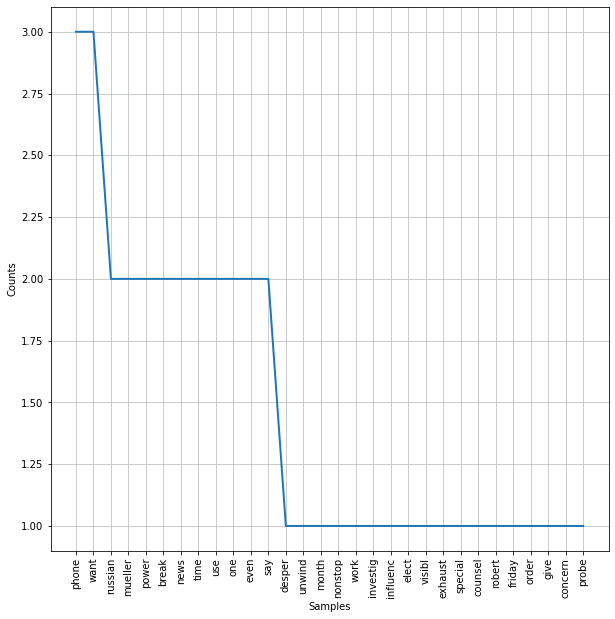

In [11]:
fdist = FreqDist(sample_doc)
plt.figure(figsize=(10, 10))
fdist.plot(30);

In [12]:
print(f'Stemming slightly reduced our token count: {len(set(sample_doc))} unique tokens')

Stemming slightly reduced our token count: 107 unique tokens


### Lemmatizing

Lemmatizing is a bit more sophisticated than the stem choppers. Lemmatizing uses part-of-speech tagging to determine how to transform a word.

- Unlike Stemming, Lemmatization reduces the inflected words, properly ensuring that the root word belongs to the language. It can handle words such as "mouse", whose plural "mice" the stemmers would not lump together with the original. 

- In Lemmatization, the root word is called the "lemma". 

- A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.

![lemmer](images/lemmer.png)

In [13]:
lemmatizer = WordNetLemmatizer()

print(f'"Mice" becomes: {lemmatizer.lemmatize("mice")}')
print(f'"Media" becomes: {lemmatizer.lemmatize(sample_doc[76])}')

# However, look at the output below:
    
sentence = "He saw the trees get sawed down"
lemmed_sentence = [lemmatizer.lemmatize(token) for token in sentence.split(' ')]
lemmed_sentence

"Mice" becomes: mouse
"Media" becomes: medium


['He', 'saw', 'the', 'tree', 'get', 'sawed', 'down']

Lemmatizers depend, for their full functionality, on POS tagging, and **the default tag is 'noun'**.

With a little bit of work, we can POS tag our text.

In [14]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(pattern)
sample_doc = tokenizer.tokenize(sample_document)
sample_doc = [token.lower() for token in sample_doc]
sample_doc = [token for token in sample_doc if token not in sw]
corpus.loc[1].body

'Desperate to unwind after months of nonstop work investigating Russian influence in the 2016 election, visibly exhausted Special Counsel Robert Mueller powered his phone down Friday in order to give himself a break from any news concerning the probe over the holiday break. “The last thing I want when I’m spending time with my family is a cascade of push notifications telling me yet another Russian oligarch, political operative, or highly placed socialite used Deutsche Bank channels to funnel money to the campaign,” said the former FBI director, firmly holding down his phone’s power button and adding that he wants to be “completely present in the moment” while celebrating with his loved ones, not ruminating about who met with which diplomat or whether someone was using social media to tamper with his witnesses. “I just want to have two calm weeks where I don’t even think about Individual One. I won’t even say his name. I’ll have to wait to hear about any important developments in Janua

In [15]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [16]:
# Use nltk's pos_tag to tag our words
# Does a pretty good job, but does make some mistakes

sample_doc_tagged = pos_tag(sample_doc)
sample_doc_tagged

[('desperate', 'JJ'),
 ('unwind', 'JJ'),
 ('months', 'NNS'),
 ('nonstop', 'JJ'),
 ('work', 'NN'),
 ('investigating', 'VBG'),
 ('russian', 'JJ'),
 ('influence', 'NN'),
 ('election', 'NN'),
 ('visibly', 'RB'),
 ('exhausted', 'VBD'),
 ('special', 'JJ'),
 ('counsel', 'NN'),
 ('robert', 'NN'),
 ('mueller', 'NN'),
 ('powered', 'VBD'),
 ('phone', 'NN'),
 ('friday', 'NN'),
 ('order', 'NN'),
 ('give', 'VBP'),
 ('break', 'NN'),
 ('news', 'NN'),
 ('concerning', 'VBG'),
 ('probe', 'NN'),
 ('holiday', 'NN'),
 ('break', 'IN'),
 ('last', 'JJ'),
 ('thing', 'NN'),
 ('want', 'VB'),
 ('spending', 'NN'),
 ('time', 'NN'),
 ('family', 'NN'),
 ('cascade', 'VBD'),
 ('push', 'JJ'),
 ('notifications', 'NNS'),
 ('telling', 'VBG'),
 ('yet', 'RB'),
 ('another', 'DT'),
 ('russian', 'JJ'),
 ('oligarch', 'NN'),
 ('political', 'JJ'),
 ('operative', 'JJ'),
 ('highly', 'RB'),
 ('placed', 'VBN'),
 ('socialite', 'NN'),
 ('used', 'VBN'),
 ('deutsche', 'NN'),
 ('bank', 'NN'),
 ('channels', 'NNS'),
 ('funnel', 'VBP'),
 ('mon

In [19]:
# Then transform the tags into the tags of our lemmatizers

def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [17]:
sample_doc_tagged

[('desperate', 'JJ'),
 ('unwind', 'JJ'),
 ('months', 'NNS'),
 ('nonstop', 'JJ'),
 ('work', 'NN'),
 ('investigating', 'VBG'),
 ('russian', 'JJ'),
 ('influence', 'NN'),
 ('election', 'NN'),
 ('visibly', 'RB'),
 ('exhausted', 'VBD'),
 ('special', 'JJ'),
 ('counsel', 'NN'),
 ('robert', 'NN'),
 ('mueller', 'NN'),
 ('powered', 'VBD'),
 ('phone', 'NN'),
 ('friday', 'NN'),
 ('order', 'NN'),
 ('give', 'VBP'),
 ('break', 'NN'),
 ('news', 'NN'),
 ('concerning', 'VBG'),
 ('probe', 'NN'),
 ('holiday', 'NN'),
 ('break', 'IN'),
 ('last', 'JJ'),
 ('thing', 'NN'),
 ('want', 'VB'),
 ('spending', 'NN'),
 ('time', 'NN'),
 ('family', 'NN'),
 ('cascade', 'VBD'),
 ('push', 'JJ'),
 ('notifications', 'NNS'),
 ('telling', 'VBG'),
 ('yet', 'RB'),
 ('another', 'DT'),
 ('russian', 'JJ'),
 ('oligarch', 'NN'),
 ('political', 'JJ'),
 ('operative', 'JJ'),
 ('highly', 'RB'),
 ('placed', 'VBN'),
 ('socialite', 'NN'),
 ('used', 'VBN'),
 ('deutsche', 'NN'),
 ('bank', 'NN'),
 ('channels', 'NNS'),
 ('funnel', 'VBP'),
 ('mon

In [20]:
sample_doc_tagged = [(token[0], get_wordnet_pos(token[1])) for
                     token in sample_doc_tagged]

sample_doc_tagged

[('desperate', 'a'),
 ('unwind', 'a'),
 ('months', 'n'),
 ('nonstop', 'a'),
 ('work', 'n'),
 ('investigating', 'v'),
 ('russian', 'a'),
 ('influence', 'n'),
 ('election', 'n'),
 ('visibly', 'r'),
 ('exhausted', 'v'),
 ('special', 'a'),
 ('counsel', 'n'),
 ('robert', 'n'),
 ('mueller', 'n'),
 ('powered', 'v'),
 ('phone', 'n'),
 ('friday', 'n'),
 ('order', 'n'),
 ('give', 'v'),
 ('break', 'n'),
 ('news', 'n'),
 ('concerning', 'v'),
 ('probe', 'n'),
 ('holiday', 'n'),
 ('break', 'n'),
 ('last', 'a'),
 ('thing', 'n'),
 ('want', 'v'),
 ('spending', 'n'),
 ('time', 'n'),
 ('family', 'n'),
 ('cascade', 'v'),
 ('push', 'a'),
 ('notifications', 'n'),
 ('telling', 'v'),
 ('yet', 'r'),
 ('another', 'n'),
 ('russian', 'a'),
 ('oligarch', 'n'),
 ('political', 'a'),
 ('operative', 'a'),
 ('highly', 'r'),
 ('placed', 'v'),
 ('socialite', 'n'),
 ('used', 'v'),
 ('deutsche', 'n'),
 ('bank', 'n'),
 ('channels', 'n'),
 ('funnel', 'v'),
 ('money', 'n'),
 ('campaign', 'n'),
 ('said', 'v'),
 ('former', 'a')

In [21]:
sample_doc_lemmed = [lemmatizer.lemmatize(token[0], token[1]) for
                     token in sample_doc_tagged]

sample_doc[:20]

['desperate',
 'unwind',
 'months',
 'nonstop',
 'work',
 'investigating',
 'russian',
 'influence',
 'election',
 'visibly',
 'exhausted',
 'special',
 'counsel',
 'robert',
 'mueller',
 'powered',
 'phone',
 'friday',
 'order',
 'give']

In [22]:
sample_doc_lemmed[:20]

['desperate',
 'unwind',
 'month',
 'nonstop',
 'work',
 'investigate',
 'russian',
 'influence',
 'election',
 'visibly',
 'exhaust',
 'special',
 'counsel',
 'robert',
 'mueller',
 'power',
 'phone',
 'friday',
 'order',
 'give']

In [23]:
print(f'There are {len(set(sample_doc_lemmed))} unique lemmas.')

There are 106 unique lemmas.


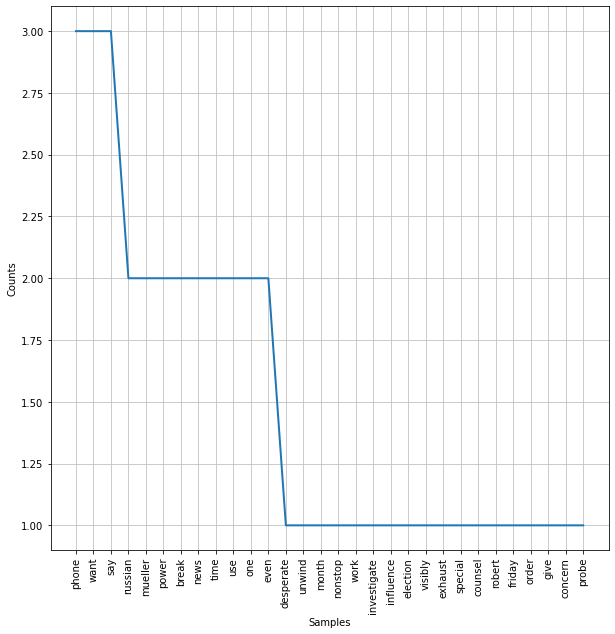

In [24]:
fdist = FreqDist(sample_doc_lemmed)
plt.figure(figsize=(10, 10))
fdist.plot(30);

In [25]:
sample_doc_lemmed

['desperate',
 'unwind',
 'month',
 'nonstop',
 'work',
 'investigate',
 'russian',
 'influence',
 'election',
 'visibly',
 'exhaust',
 'special',
 'counsel',
 'robert',
 'mueller',
 'power',
 'phone',
 'friday',
 'order',
 'give',
 'break',
 'news',
 'concern',
 'probe',
 'holiday',
 'break',
 'last',
 'thing',
 'want',
 'spending',
 'time',
 'family',
 'cascade',
 'push',
 'notification',
 'tell',
 'yet',
 'another',
 'russian',
 'oligarch',
 'political',
 'operative',
 'highly',
 'place',
 'socialite',
 'use',
 'deutsche',
 'bank',
 'channel',
 'funnel',
 'money',
 'campaign',
 'say',
 'former',
 'fbi',
 'director',
 'firmly',
 'hold',
 'phone',
 'power',
 'button',
 'add',
 'want',
 'completely',
 'present',
 'moment',
 'celebrate',
 'love',
 'one',
 'ruminate',
 'meet',
 'diplomat',
 'whether',
 'someone',
 'use',
 'social',
 'medium',
 'tamper',
 'witness',
 'want',
 'two',
 'calm',
 'week',
 'even',
 'think',
 'individual',
 'one',
 'even',
 'say',
 'name',
 'wait',
 'hear',
 'i

## Feature Engineering for NLP

The machine learning algorithms we have encountered so far represent features as the variables that take on different value for each observation. For example, we represent individuals with distinct education levels, incomes, and such. However, in NLP, features are represented in a very different way. In order to pass text data to machine learning algorithms and perform classification, we need to represent the features in a sensible way. One such method is called **Bag-of-words (BoW)**.

A bag-of-words model, or BoW for short, is a way of extracting features from text for use in modeling. A bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:

- A vocabulary of known words.
- A measure of the presence of known words.

It is called a “bag” of words **because any information about the order or structure of words in the document is discarded**. The model is only concerned with whether known words occur in the document, not with **where** they may occur in the document. The intuition behind BoW is that a document is similar to another if they have similar contents. The Bag of Words method can be represented as a **Document Term Matrix**, in which each column is a unique vocabulary n-gram and each observation is a document. Consider, for example, the following **corpus** of documents:

- Document 1: "I love dogs."
- Document 2: "I love cats."
- Document 3: "I love all animals."
- Document 4: "I hate dogs."

This corpus can be represented as:

$\downarrow$Doc\|Word$\rightarrow$|I|love|dogs|cats|all|animals|hate
-|-|-|-|-|-|-|-
Document_1|1|1|1|0|0|0|0
Document_2|1|1|0|1|0|0|0
Document_3|1|1|0|0|1|1|0
Document_4|1|0|1|0|0|0|1

## Vectorization

In order to get these tokens from our documents, we're going to use tools called "vectorizers".

The most straightforward vectorizer in `sklearn.feature_extraction.text` is the `CountVectorizer`, which will simply count the number of each word type in each document.

### `CountVectorizer`

In [26]:
sample_doc_lemmed

['desperate',
 'unwind',
 'month',
 'nonstop',
 'work',
 'investigate',
 'russian',
 'influence',
 'election',
 'visibly',
 'exhaust',
 'special',
 'counsel',
 'robert',
 'mueller',
 'power',
 'phone',
 'friday',
 'order',
 'give',
 'break',
 'news',
 'concern',
 'probe',
 'holiday',
 'break',
 'last',
 'thing',
 'want',
 'spending',
 'time',
 'family',
 'cascade',
 'push',
 'notification',
 'tell',
 'yet',
 'another',
 'russian',
 'oligarch',
 'political',
 'operative',
 'highly',
 'place',
 'socialite',
 'use',
 'deutsche',
 'bank',
 'channel',
 'funnel',
 'money',
 'campaign',
 'say',
 'former',
 'fbi',
 'director',
 'firmly',
 'hold',
 'phone',
 'power',
 'button',
 'add',
 'want',
 'completely',
 'present',
 'moment',
 'celebrate',
 'love',
 'one',
 'ruminate',
 'meet',
 'diplomat',
 'whether',
 'someone',
 'use',
 'social',
 'medium',
 'tamper',
 'witness',
 'want',
 'two',
 'calm',
 'week',
 'even',
 'think',
 'individual',
 'one',
 'even',
 'say',
 'name',
 'wait',
 'hear',
 'i

In [28]:
" ".join(sample_doc_lemmed)

'desperate unwind month nonstop work investigate russian influence election visibly exhaust special counsel robert mueller power phone friday order give break news concern probe holiday break last thing want spending time family cascade push notification tell yet another russian oligarch political operative highly place socialite use deutsche bank channel funnel money campaign say former fbi director firmly hold phone power button add want completely present moment celebrate love one ruminate meet diplomat whether someone use social medium tamper witness want two calm week even think individual one even say name wait hear important development january since know second read say something eric involve deeply previously suspect get pull back ruin whole vacation press time mueller reactivate phone check news real quick'

In [30]:
# implementing it in python

# Convert a collection of text documents to a matrix of token counts

vec = CountVectorizer()
X = vec.fit_transform([" ".join(sample_doc_lemmed)])


df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df.head()

,add,another,back,bank,break,button,calm,campaign,cascade,celebrate,...,vacation,visibly,wait,want,week,whether,whole,witness,work,yet
0,1,1,1,1,2,1,1,1,1,1,...,1,1,1,3,1,1,1,1,1,1


In [31]:
vec.vocabulary_

{'desperate': 16,
 'unwind': 94,
 'month': 50,
 'nonstop': 54,
 'work': 104,
 'investigate': 40,
 'russian': 77,
 'influence': 39,
 'election': 21,
 'visibly': 97,
 'exhaust': 24,
 'special': 85,
 'counsel': 14,
 'robert': 74,
 'mueller': 51,
 'power': 63,
 'phone': 60,
 'friday': 29,
 'order': 59,
 'give': 32,
 'break': 4,
 'news': 53,
 'concern': 13,
 'probe': 67,
 'holiday': 36,
 'last': 44,
 'thing': 90,
 'want': 99,
 'spending': 86,
 'time': 92,
 'family': 25,
 'cascade': 8,
 'push': 69,
 'notification': 55,
 'tell': 89,
 'yet': 105,
 'another': 1,
 'oligarch': 56,
 'political': 62,
 'operative': 58,
 'highly': 34,
 'place': 61,
 'socialite': 82,
 'use': 95,
 'deutsche': 17,
 'bank': 3,
 'channel': 10,
 'funnel': 30,
 'money': 49,
 'campaign': 7,
 'say': 78,
 'former': 28,
 'fbi': 26,
 'director': 20,
 'firmly': 27,
 'hold': 35,
 'button': 5,
 'add': 0,
 'completely': 12,
 'present': 64,
 'moment': 48,
 'celebrate': 9,
 'love': 45,
 'one': 57,
 'ruminate': 76,
 'meet': 47,
 'diplo

That is not very exciting for one document. The idea is to make a document term matrix for all of the words in our corpus.

In [32]:
corpus

,body,target
0,Noting that the resignation of James Mattis as...,1
1,Desperate to unwind after months of nonstop wo...,1
2,"Nearly halfway through his presidential term, ...",1
3,Attempting to make amends for gross abuses of ...,1
4,Decrying the Senate’s resolution blaming the c...,1
...,...,...
995,Britain’s opposition leader Jeremy Corbyn wou...,0
996,Turkey will take over the fight against Islam...,0
997,Malaysia is seeking $7.5 billion in reparatio...,0
998,An Israeli court sentenced a Palestinian to 1...,0


In [37]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw)
X = vec.fit_transform(corpus.body[0:3])

df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df.head()

,adding,administration,advisor,also,americans,another,assholes,back,bank,beginning,...,want,wants,weeks,whether,whole,witnesses,work,worried,year,yet
0,0,1,1,1,1,0,1,1,0,1,...,0,0,1,0,0,0,0,1,2,0
1,1,0,0,0,0,1,0,1,1,0,...,2,1,1,1,1,1,1,0,0,1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
# Can change the 'token length'
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw,
                      ngram_range=[1, 2])
X = vec.fit_transform(corpus.body[0:3])

df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df.head()

,adding,adding wants,administration,administration official,advisor,advisor michael,also,also noting,americans,americans also,...,witnesses want,work,work investigating,worried,worried populace,year,year country,year old,yet,yet another
0,0,0,1,1,1,1,1,1,1,1,...,0,0,0,1,1,2,1,1,0,0
1,1,1,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Our document term matrix gets bigger and bigger, with more and more zeros, becoming sparser and sparser.

In [47]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw,
                      ngram_range=[1, 1])
# Now fit to the entire corpus
X = vec.fit_transform(corpus.body)

df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df.head()

,aa,aaaaaaah,aaaaaah,aaaaargh,aaaah,aaah,aaargh,aah,aahing,aap,...,zoos,zor,zozovitch,zte,zuckerberg,zuercher,zverev,zych,zzouss,zzzzzst
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
df['aaaaaaah'].sum()

1

In [ ]:
df

We can set upper and lower limits to the word frequency:

In [49]:
corpus.body

0      Noting that the resignation of James Mattis as...
1      Desperate to unwind after months of nonstop wo...
2      Nearly halfway through his presidential term, ...
3      Attempting to make amends for gross abuses of ...
4      Decrying the Senate’s resolution blaming the c...
                             ...                        
995     Britain’s opposition leader Jeremy Corbyn wou...
996     Turkey will take over the fight against Islam...
997     Malaysia is seeking $7.5 billion in reparatio...
998     An Israeli court sentenced a Palestinian to 1...
999     At least 22 people have died due to landslide...
Name: body, Length: 1000, dtype: object

In [51]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",
                      stop_words=sw, ngram_range=[1, 1],
                      min_df=, max_df=25)
X = vec.fit_transform(corpus.body)

df_cv = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df_cv

,aaron,abandon,abandoned,abandoning,abandonment,abbas,abdul,abhor,abide,abroad,...,youngest,youth,youtube,ypg,zealand,zero,zia,zone,zones,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,5,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",
                      stop_words=sw, ngram_range=[1, 2], max_features=200)
X = vec.fit_transform(corpus.body)

df_cv = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df_cv

,according,across,agency,already,also,america,american,another,anti,around,...,well,white,within,without,women,work,world,would,year,years
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,8,2,0
996,0,1,0,0,1,1,3,0,0,0,...,0,0,0,0,0,1,0,6,2,0
997,0,0,1,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
998,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,2,2,1


### `TfidfVectorizer`

There are many schemas for determining the values of each entry in a document term matrix, and one of the most common uses the TF-IDF algorithm -- "Term Frequency-Inverse Document Frequency". Essentially, tf-idf *normalizes* the raw count of the document term matrix. And it represents how important a word is in the given document. 

> The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

- TF (Term Frequency)
Term frequency is the frequency of the word in the document divided by the total words in the document.

- IDF (inverse document frequency)
Inverse document frequency is a measure of how much information the word provides, i.e., if it's common or rare across all documents. It is generally calculated as the logarithmically scaled inverse fraction of the documents that contain the word (obtained by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that quotient):

$$idf(w) = log (\frac{number\ of\ documents}{num\ of\ documents\ containing\ w})$$

tf-idf is the product of term frequency and inverse document frequency, or tf * idf. 

In [56]:
tf_vec = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw)
X = tf_vec.fit_transform(corpus.body)

df = pd.DataFrame(X.toarray(), columns=tf_vec.get_feature_names())
df.head()

,aa,aaaaaaah,aaaaaah,aaaaargh,aaaah,aaah,aaargh,aah,aahing,aap,...,zoos,zor,zozovitch,zte,zuckerberg,zuercher,zverev,zych,zzouss,zzzzzst
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
corpus.iloc[313].body

'Power nerds, these are a special breed of techie nerds who want to take over the world with their technological prowess. From the birth of the World Wide Web, these power nerds have created and grown companies that are now monopolies controlling every facet of people’s lives. Smartphones, apps, search engines, social networks – power nerds are in everything, their power increases daily as more millions of people use their networks. Power nerds are ruthless, they are creatures who do not balk in crushing their opponents completely without mercy and their greed for complete controlling power over everything is boundless. To quote a few examples of companies that are run by ruthless power nerds, we can of course cite Facebook, Twitter, Amazon and Google. These companies are not only seeking to rule and control everything, they also are using their power to manipulate data taken from their platforms to make money and increase their influence, as well as shut down any voices that are not l

In [58]:
df.iloc[313].sort_values(ascending=False)[:10]

nerds         0.600312
power         0.396376
companies     0.168090
billions      0.140697
facebook      0.129217
ruthless      0.127204
company       0.106695
evil          0.104667
zuckerberg    0.098663
people        0.095626
Name: 313, dtype: float64

Let's compare the tfidf to the count vectorizer output for one document.

In [59]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw)
X = vec.fit_transform(corpus.body)

df_cv = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df_cv

,aa,aaaaaaah,aaaaaah,aaaaargh,aaaah,aaah,aaargh,aah,aahing,aap,...,zoos,zor,zozovitch,zte,zuckerberg,zuercher,zverev,zych,zzouss,zzzzzst
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
df_cv.iloc[313].sort_values(ascending=False)[:10]

power        18
nerds        11
people        7
companies     6
one           4
also          4
billions      4
facebook      4
company       4
data          3
Name: 313, dtype: int64

In [61]:
df.iloc[313].sort_values(ascending=False)[:10]

nerds         0.600312
power         0.396376
companies     0.168090
billions      0.140697
facebook      0.129217
ruthless      0.127204
company       0.106695
evil          0.104667
zuckerberg    0.098663
people        0.095626
Name: 313, dtype: float64

The tfidf lessoned the importance of some of the more common words, including a word, "also", which might have made it into the stopword list.

It also assigns "nerds" more weight than power.  

In [62]:
print(f'"Nerds" only shows up in document 313: {len(df_cv[df.nerds!=0])} document.')
print(f'"Power" shows up in {len(df_cv[df.power!=0])} documents!')

"Nerds" only shows up in document 313: 1 document.
"Power" shows up in 147 documents!


All the words are stored in a `.vocabulary_` attribute:

In [63]:
tf_vec.vocabulary_

{'noting': 14228,
 'resignation': 17453,
 'james': 11083,
 'mattis': 12876,
 'secretary': 18493,
 'defense': 5328,
 'marked': 12753,
 'ouster': 14711,
 'third': 21062,
 'top': 21291,
 'administration': 293,
 'official': 14445,
 'less': 12042,
 'three': 21096,
 'weeks': 22859,
 'worried': 23186,
 'populace': 15784,
 'told': 21257,
 'reporters': 17365,
 'friday': 8389,
 'unsure': 22126,
 'many': 12705,
 'former': 8261,
 'trump': 21633,
 'staffers': 19832,
 'could': 4654,
 'safely': 18072,
 'reabsorb': 16838,
 'jesus': 11159,
 'take': 20693,
 'back': 1540,
 'assholes': 1254,
 'need': 13936,
 'time': 21177,
 'process': 16146,
 'one': 14516,
 'get': 8762,
 'next': 14045,
 'said': 18088,
 'year': 23301,
 'old': 14477,
 'gregory': 9106,
 'birch': 2136,
 'naperville': 13830,
 'il': 10220,
 'echoing': 6555,
 'concerns': 4203,
 'million': 13240,
 'americans': 723,
 'also': 658,
 'country': 4674,
 'truly': 21632,
 'beginning': 1905,
 'reintegrate': 17182,
 'national': 13870,
 'security': 18511,
 

### `HashingVectorizer`

There is also a hashing vectorizer, which will encrypt all the words of the corpus.

In [64]:
hvec = HashingVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",
                         stop_words=sw)
X = hvec.fit_transform(corpus.body)

df_cv = pd.DataFrame(X.toarray())
df_cv

,0,1,2,3,4,5,6,7,8,9,...,1048566,1048567,1048568,1048569,1048570,1048571,1048572,1048573,1048574,1048575
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.167248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Some rules of thumb about these vectorizers:

**Tf-Idf**: Probably the most commonly used. Useful when the goal is to distinguish the **content** of documents from others in the corpus.

**Count**: Useful when the words themselves matter. If the goal is instead about identifying authors by their words, then the fact that some word appears in many documents of the corpus may be important.

**Hashing**: The advantage here is speed and low memory usage. The disadvantage is that you lose the identities of the words being tokenized. Useful for very large datasets where the ultimate model may be a bit of a black box.

## Exercise

Create a document term matrix of the 1000-document corpus. The vocabulary should have no stopwords, numbers, or punctuation, and it should be lemmatized. Use a `TfidfVectorizer`.



<details>
    <summary>Answer</summary>
    <code># Tokenizing
tokenized_docs = [tokenizer.tokenize(doc) for doc in corpus['body']]
lower_docs = [[token.lower() for token in doc] for doc in tokenized_docs]
sw_docs = [[token for token in doc if token not in sw] for doc in lower_docs]
# Initial tagging
docs_tagged = [pos_tag(doc) for doc in sw_docs]
# Tag with Wordnet tags
wordnet_docs_tagged = [[(token[0], get_wordnet_pos(token[1]))
             for token in doc] for doc in docs_tagged]
# Lemmatize
docs_lemmed = [[lemmatizer.lemmatize(token[0], token[1]) for token in doc]\
               for doc in wordnet_docs_tagged]
# Use the tf-idf vectorizer to create the matrix
X = tf_vec.fit_transform([' '.join(doc) for doc in docs_lemmed])
df = pd.DataFrame(X.toarray(), columns=tf_vec.get_feature_names())</code>
</details>

## Naive Bayes and NLP Modeling

Before returning to our satire / no-satire example, let's consider an example with a smaller but similar scope.

Suppose we are using an API to gather articles from a news website and grabbing phrases from two different types of articles:  **music** and **politics**.

But we have a problem. Only some of our articles have an indication of their category (music or politics). Is there a way we can use Machine Learning to help us label our data **quickly**?

-------------------------------
### Here are our articles
#### Music Articles:

* 'the song was popular'
* 'band leaders disagreed on sound'
* 'played for a sold out arena stadium'

#### Politics Articles

* 'world leaders met lask week'
* 'the election was close'
* 'the officials agreed on a compromise'
--------------------------------------------------------
Let's try and predict one example phrase:

* "world leaders agreed to fund the stadium"

How can we make a model that labels this for us rather than having to go through by hand?

In [65]:
music = ['the song was popular',
         'band leaders disagreed on sound',
         'played for a sold out arena stadium']

politics = ['world leaders met last week',
            'the election was close',
            'the officials agreed on a compromise']

test_statement = 'world leaders agreed to fund the stadium'

In [66]:
#labels : {'music', 'politics'}
#features: words
test_statement_2 = 'officials met at the arena'

### Bayes's Theorem Again

Let's revisit Bayes's Theorem. Remember, the idea is to calculate the probability of the correct application of a class label (c) given some data (x). To do so, we calculate the **likelihood** (the distribution of our data within a given class) and the **prior** probabiliity of each class (the probability of seeing the class in the population). We are going generally to ignore the denominator of the right side of the equation because it will be constant.

<img src ="images/naive_bayes_icon.png">

### Another way of looking at it
<img src = "images/another_one.png">

## So, in the context of our problem......



$\large P(politics | phrase) = \frac{P(phrase|politics)P(politics)}{P(phrase)}$

$\large P(politics) = \frac{ \# politics}{\# all\ articles} $

*where phrase is our test statement*

<img src = "images/solving_theta.png" width="400">

### How should we calculate $P(politics)$?

This is essentially the distribution of the probability of either type of article. We have three of each type of article, therefore, we assume that there is an equal probability of either article

In [67]:
p_politics = len(politics) / (len(politics) + len(music))
p_music = len(music) / (len(politics) + len(music))

In [68]:
p_politics

0.5

In [69]:
p_music

0.5

### How should we calculate $P(phrase | politics)$?

We'll break the phrase down into individual words.

$\large P(phrase | politics) = \prod_{i=1}^{d} P(word_{i} | politics) $

**This is where the naivety of Naive Bayes comes in in this context. We assume that the predictive relevances of words are mutually independent.**

In practice, of course, this sounds rather unrealistic. But it greatly simplifies the Bayesian calculation.

$\large P(word_{i} | politics) = \frac{\#\ of\ word_{i}\ in\ politics\ articles} {\#\ of\ total\ words\ in\ politics\ articles} $

## Laplace Smoothing

In practice, the calculation of probabilities is often adjusted slightly to avoid zeroes.

$\large P(word_{i} | politics) = \frac{\#\ of\ word_{i}\ in\ politics\ articles \bf{+ \alpha}} {\#\ of\ total\ words\ in\ politics\ articles \bf{+ \alpha d}} $

$\large P(word_{i} | music) = \frac{\#\ of\ word_{i}\ in\ music\ articles \bf{+ \alpha}} {\#\ of\ total\ words\ in\ music\ articles \bf{+ \alpha d}}$

This correction process is called Laplace smoothing:

* d : number of features (in this instance total number of vocabulary words)
* $\alpha$ can be any number greater than 0 (it is usually 1)


#### Now let's find this calculation

In [70]:
def vocab_maker(category):
    """
    parameters: category is a list containing all the articles
    of a given category.
    
    returns the vocabulary for a given type of article
    
    """
    
    vocab_category = set() # will filter down to only unique words
    
    for art in category:
        words = art.split()
        for word in words:
            vocab_category.add(word)
    return vocab_category

In [71]:
voc_music = vocab_maker(music)
voc_pol = vocab_maker(politics)

In [72]:
# These are all the unique words in the music category
voc_music

{'a',
 'arena',
 'band',
 'disagreed',
 'for',
 'leaders',
 'on',
 'out',
 'played',
 'popular',
 'sold',
 'song',
 'sound',
 'stadium',
 'the',
 'was'}

In [73]:
# These are all the unique words in the politics category
voc_pol

{'a',
 'agreed',
 'close',
 'compromise',
 'election',
 'last',
 'leaders',
 'met',
 'officials',
 'on',
 'the',
 'was',
 'week',
 'world'}

In [76]:
voc_shared = voc_music.intersection(voc_pol)
voc_shared

{'a', 'leaders', 'on', 'the', 'was'}

In [74]:
# The union of the two sets gives us the unique words across both article groups
voc_all = voc_music.union(voc_pol)
voc_all

{'a',
 'agreed',
 'arena',
 'band',
 'close',
 'compromise',
 'disagreed',
 'election',
 'for',
 'last',
 'leaders',
 'met',
 'officials',
 'on',
 'out',
 'played',
 'popular',
 'sold',
 'song',
 'sound',
 'stadium',
 'the',
 'was',
 'week',
 'world'}

In [77]:
total_vocab_count = len(voc_all)
total_music_count = len(voc_music)
total_politics_count = len(voc_pol)

Let's remind ourselves of the goal, to see the posterior probability of the class politics given our phrase. 

> P(politics | "leaders agreed to fund the stadium")

In [78]:
def find_number_words_in_category(phrase, category):
    
    """This function will help us calculate our likelihoods
    by constructing a dictionary of counts of how many times
    each word in our test phrase appears in articles of a
    given category."""
    
    statement = phrase.split()
    
    # category is a list of the raw documents of each category
    str_category = ' '.join(category)
    cat_word_list = str_category.split()
    word_count = defaultdict(int)
    
    # loop through each word in the phrase
    for word in statement:
        # loop through each word in the category
        for art_word in cat_word_list:
            if word == art_word:
                # count the number of times the phrase word occurs in the category
                word_count[word] += 1
            else:
                word_count[word]
    return word_count

In [83]:
music

['the song was popular',
 'band leaders disagreed on sound',
 'played for a sold out arena stadium']

In [79]:
test_music_word_count = find_number_words_in_category(test_statement, music)

In [80]:
test_music_word_count

defaultdict(int,
            {'world': 0,
             'leaders': 1,
             'agreed': 0,
             'to': 0,
             'fund': 0,
             'the': 1,
             'stadium': 1})

Let's remind ourselves of our music articles:

In [81]:
music

['the song was popular',
 'band leaders disagreed on sound',
 'played for a sold out arena stadium']

In [82]:
test_music_word_count

defaultdict(int,
            {'world': 0,
             'leaders': 1,
             'agreed': 0,
             'to': 0,
             'fund': 0,
             'the': 1,
             'stadium': 1})

In [84]:
test_politic_word_count = find_number_words_in_category(test_statement, politics)

Let's remind ourselves of our politics articles:

In [85]:
politics

['world leaders met last week',
 'the election was close',
 'the officials agreed on a compromise']

In [86]:
test_politic_word_count

defaultdict(int,
            {'world': 1,
             'leaders': 1,
             'agreed': 1,
             'to': 0,
             'fund': 0,
             'the': 2,
             'stadium': 0})

In [87]:
def find_likelihood_with_smooth(category_count, test_category_count, alpha):
    
    # The numerator will be the product of all the counts 
    # with the smoothing factor (alpha) to make sure the probability is not zeroed out.
    # Because we're being officially "naïve", we'll simply multiply these all together.
    num = np.product(np.array(list(test_category_count.values())) + alpha)
    
    # The denominator will be the same for each word (total category count + total vocab
    # + alpha), so we raise it to the power of the length of the test category (d =
    # total_vocab_count)
    denom = (category_count + total_vocab_count*alpha)**(len(test_category_count))
    
    return num / denom

In [88]:
likelihood_m = find_likelihood_with_smooth(total_music_count, test_music_word_count, 1)

In [89]:
likelihood_p = find_likelihood_with_smooth(total_politics_count, test_politic_word_count, 1)

In [90]:
print(likelihood_m)
print(likelihood_p)

4.107740405680756e-11
1.748875897714495e-10


 $ P(politics | article) = P(politics) x \prod_{i=1}^{d} P(word_{i} | politics) $

#### Deteriming the winner of our model:

<img src = "images/solvingforyhat.png" width= "400">

In [91]:
# p(politics|article)  > p(music|article)
likelihood_p * p_politics  > likelihood_m * p_music

True

In [92]:
likelihood_p * p_politics

8.744379488572475e-11

In [93]:
likelihood_m * p_music

2.053870202840378e-11

Many times, the probabilities we end up with are exceedingly small, so we can transform them using logarithms to save on computation speed. This takes advantage of the nice mathematical feature that the log of a product of factors is equal to the sum of the logs of the individual factors, i.e.:

$log(xy) = log(x) + log(y)$

$\large log(P(politics | article)) = log(P(politics)) + \sum_{i=1}^{d}log( P(word_{i} | politics)) $





Good Resource: https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html

## Back to Satire

In [94]:
# Recall our corpus
corpus.head()

,body,target
0,Noting that the resignation of James Mattis as...,1
1,Desperate to unwind after months of nonstop wo...,1
2,"Nearly halfway through his presidential term, ...",1
3,Attempting to make amends for gross abuses of ...,1
4,Decrying the Senate’s resolution blaming the c...,1


Like always, we will perform a train test split...

In [109]:
X = corpus[['body']]
y = corpus.target

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25)

In [112]:
X_train

,body
82,"Perpetually offended Social Justice Warrior, a..."
991,"Ana Luz, sister-in-law of Ronald Blanco, look..."
789,Pope Francis accused U.S. bishops on Thursday...
894,"Augusto Heleno, Brazil’s new minister of inst..."
398,hansard.parliament.uk Somewhere under here is ...
...,...
106,The visiting contingent of communist Chinese c...
270,Manufacturers of the newly unveiled robot call...
860,Britain’s Royal Mail apologised on Friday aft...
435,Kim Jong-Un set up an amazing fireworks show f...


... and preprocess the training set.

In [97]:
# Bring in stopwords

sw = stopwords.words('english')

In [98]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [99]:
lemmatizer = WordNetLemmatizer() 

In [100]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the satire corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    tokens = regex_token.tokenize(doc)
    lowered_t = [word.lower() for word in tokens]
    no_sw_t = [word for word in lowered_t if word not in sw]
    # print(doc)
    tokens_tagged = pos_tag(no_sw_t)
    pos_tokens = [(word[0], get_wordnet_pos(word[1])) for word in tokens_tagged] 
    tokens_lemm = [lemmatizer.lemmatize(word[0], word[1]) for word in pos_tokens]
    return ' '.join(tokens_lemm)

In [101]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]

In [103]:
len(token_docs)

750

In [104]:
corpus['processed'] = corpus['body'].apply(doc_preparer)
corpus.head()

,body,target,processed
0,Noting that the resignation of James Mattis as...,1,note resignation james mattis secretary defens...
1,Desperate to unwind after months of nonstop wo...,1,desperate unwind month nonstop work investigat...
2,"Nearly halfway through his presidential term, ...",1,nearly halfway presidential term donald trump ...
3,Attempting to make amends for gross abuses of ...,1,attempt make amends gross abuse power time int...
4,Decrying the Senate’s resolution blaming the c...,1,decry senate’s resolution blame crown prince b...


In [113]:
X_train['cleaned'] = X_train['body'].apply(doc_preparer)

<ipython-input-113-d70eb88badac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['cleaned'] = X_train['body'].apply(doc_preparer)


In [114]:
X_train.head()

,body,cleaned
82,"Perpetually offended Social Justice Warrior, a...",perpetually offend social justice warrior keen...
991,"Ana Luz, sister-in-law of Ronald Blanco, look...",ana luz sister law ronald blanco look grimly n...
789,Pope Francis accused U.S. bishops on Thursday...,pope francis accuse u bishop thursday fail sho...
894,"Augusto Heleno, Brazil’s new minister of inst...",augusto heleno brazil’s new minister instituti...
398,hansard.parliament.uk Somewhere under here is ...,hansard parliament uk somewhere answer problem...


For demonstration purposes, we will **limit our count vectorizer to 5 words** (the top 5 words by frequency).

In [115]:
# Secondary train-test split to build our best model
X_t, X_val, y_t, y_val = train_test_split(X_train['cleaned'], y_train,
                                          test_size=0.25, random_state=42)

cv = CountVectorizer(max_features=5)

X_t_vec = cv.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

In [116]:
X_t_vec

,one,people,say,would,year
159,2,3,0,1,0
246,3,1,0,2,1
640,0,0,5,0,4
809,2,2,10,1,7
130,1,0,0,4,0
...,...,...,...,...,...
148,1,1,1,3,1
300,0,0,1,1,0
356,4,1,3,4,0
36,4,1,6,3,3


In [117]:
# We then transform the validation set. (Do not refit the vectorizer!)

X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

### Multinomial Naive Bayes

Now let's fit the the Multinomial Naive Bayes Classifier on our training data

In [118]:
mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)

MultinomialNB()

In [119]:
#What should our priors for each class be?

prior_0 = y_t.value_counts()[0]/len(y_t)
prior_1 = y_t.value_counts()[1]/len(y_t)
print(prior_0, prior_1)

0.48576512455516013 0.5142348754448398


In [120]:
y_t.value_counts(normalize=True)

1    0.514235
0    0.485765
Name: target, dtype: float64

The classifier has a `.class_log_prior_` attribute (once fitted).

In [121]:
mnb.class_log_prior_

array([-0.72203005, -0.66507516])

And it simply contains the logged values of the priors:

In [122]:
np.exp(mnb.class_log_prior_[0])

0.4857651245551603

In [123]:
np.log(prior_0)

-0.7220300547087314

Generate model predictions and get an accuracy score!

In [124]:
mnb.score(X_t_vec, y_t)

0.8398576512455516

In [125]:
y_hat = mnb.predict(X_val_vec)
accuracy_score(y_val, y_hat)

0.9095744680851063

Let's consider the scenario that we would like to isolate satirical news on Facebook so we can flag it. We do not want to flag real news by mistake. In other words, we want to minimize false positives.

In [126]:
from sklearn.metrics import plot_confusion_matrix

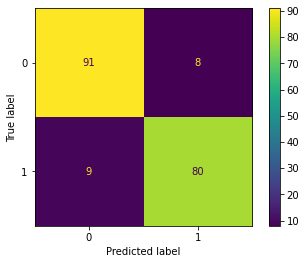

In [127]:
plot_confusion_matrix(mnb, X_val_vec, y_val);

In [128]:
precision_score(y_val, y_hat)

0.9090909090909091

That's pretty good for a five word vocabulary.

Let's see what happens when we don't restrict our vocabulary.

In [129]:
cv = CountVectorizer()
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)


X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

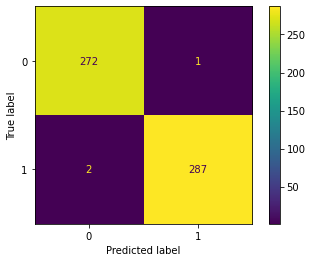

In [130]:
mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)
plot_confusion_matrix(mnb, X_t_vec, y_t);

In [131]:
precision_score(y_t, mnb.predict(X_t_vec))

0.9965277777777778

Wow! Look how well that performed. 

In [132]:
precision_score(y_val, y_hat)

0.9550561797752809

In [133]:
len(cv.vocabulary_)

14834

In [142]:
mnb.coef_[0]

array([-10.66212983, -10.66212983, -10.66212983, ..., -11.35527701,
       -10.66212983, -11.35527701])

In [147]:
mnb.feature_log_prob_[0]

array([-11.211496  , -11.211496  , -11.211496  , ..., -10.51834881,
       -11.211496  , -10.51834881])

Let's see whether or not we can maintain that level of accuracy with fewer words.

In [148]:
cv = CountVectorizer(min_df=0.05, max_df=0.95)
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)

precision_score(y_val, y_hat)

0.9425287356321839

In [149]:
len(cv.vocabulary_)

651

In [ ]:
# Now let's see what happens with TF-IDF

In [150]:
tfidf = TfidfVectorizer()
X_t_vec = tfidf.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_val_vec = tfidf.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)

precision_score(y_val, y_hat)

0.9444444444444444

In [151]:
precision_score(y_t, mnb.predict(X_t_vec))

0.993103448275862

TFIDF does not necessarily perform better than CV. It is just a tool in our toolbelt that's often worth trying out.

In [152]:
len(tfidf.vocabulary_)

14834

In [153]:
tfidf = TfidfVectorizer(min_df=0.05, max_df=0.95)
X_t_vec = tfidf.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_val_vec = tfidf.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)

precision_score(y_val, y_hat)

0.9651162790697675

In [154]:
precision_score(y_t, mnb.predict(X_t_vec))

0.9659863945578231

In [155]:
len(tfidf.vocabulary_)

651

In [165]:
list(X_t_vec.columns)

['able',
 'access',
 'accord',
 'account',
 'accuse',
 'across',
 'act',
 'action',
 'actually',
 'add',
 'additional',
 'address',
 'administration',
 'affair',
 'age',
 'agency',
 'ago',
 'agree',
 'ahead',
 'aim',
 'air',
 'al',
 'allow',
 'ally',
 'almost',
 'along',
 'already',
 'also',
 'although',
 'always',
 'america',
 'american',
 'among',
 'amongst',
 'amount',
 'announce',
 'another',
 'answer',
 'anti',
 'anyone',
 'anything',
 'appear',
 'area',
 'arm',
 'army',
 'around',
 'arrest',
 'ask',
 'attack',
 'attempt',
 'authority',
 'avoid',
 'away',
 'back',
 'bad',
 'ban',
 'bank',
 'base',
 'become',
 'begin',
 'behind',
 'believe',
 'benefit',
 'best',
 'big',
 'billion',
 'black',
 'block',
 'blood',
 'body',
 'book',
 'border',
 'break',
 'brexit',
 'bring',
 'britain',
 'british',
 'brussels',
 'build',
 'business',
 'cabinet',
 'call',
 'campaign',
 'can',
 'candidate',
 'cannot',
 'capital',
 'carry',
 'case',
 'cause',
 'central',
 'centre',
 'certain',
 'certainly'

Let's compare MNB to Random Forest:

In [156]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=5)
rf.fit(X_t_vec, y_t)
y_hat = rf.predict(X_val_vec)
precision_score(y_val, y_hat)

0.9560439560439561

In [157]:
precision_score(y_t, rf.predict(X_t_vec))

0.993103448275862

In [163]:
len(rf.feature_importances_)

651

In [166]:
dict(zip(list(X_t_vec.columns), rf.feature_importances_))

{'able': 0.00016722592456886752,
 'access': 9.35148140240008e-05,
 'accord': 0.0004340646276853016,
 'account': 0.0002432261053033315,
 'accuse': 0.0008343734549009447,
 'across': 0.00042938734924937615,
 'act': 0.0002701532680124637,
 'action': 0.0003338586006038523,
 'actually': 0.00025613396781869224,
 'add': 0.0007717586487988402,
 'additional': 0.00016505775651421401,
 'address': 0.00014988863397879634,
 'administration': 0.0005883207842743711,
 'affair': 0.00011432072275902398,
 'age': 0.00020572592788189046,
 'agency': 0.0013162335476732334,
 'ago': 9.714728589608931e-05,
 'agree': 4.598889428577049e-05,
 'ahead': 0.00016895667051463148,
 'aim': 0.0005248231162892937,
 'air': 0.00015726126729923606,
 'al': 0.00017459210287423493,
 'allow': 0.0002504900701637581,
 'ally': 0.0023156596421966473,
 'almost': 4.9684775287307003e-05,
 'along': 0.00015705063470718419,
 'already': 0.00019604616517835565,
 'also': 0.0003401840569168579,
 'although': 0.0002564201045949525,
 'always': 0.00

The two perform comparably, but MNB is lightweight as far as computational power and speed. For real-time predictions, we may choose MNB over Random Forest because the classifications can be performed quickly.

## You can feed the doc_preparer function directly to the vectorizor

#### Specify the preprocessor arguement in the vectorizor

In [158]:
X_train

,body,cleaned
82,"Perpetually offended Social Justice Warrior, a...",perpetually offend social justice warrior keen...
991,"Ana Luz, sister-in-law of Ronald Blanco, look...",ana luz sister law ronald blanco look grimly n...
789,Pope Francis accused U.S. bishops on Thursday...,pope francis accuse u bishop thursday fail sho...
894,"Augusto Heleno, Brazil’s new minister of inst...",augusto heleno brazil’s new minister instituti...
398,hansard.parliament.uk Somewhere under here is ...,hansard parliament uk somewhere answer problem...
...,...,...
106,The visiting contingent of communist Chinese c...,visit contingent communist chinese censor visi...
270,Manufacturers of the newly unveiled robot call...,manufacturer newly unveil robot call amazos cl...
860,Britain’s Royal Mail apologised on Friday aft...,britain’s royal mail apologise friday historia...
435,Kim Jong-Un set up an amazing fireworks show f...,kim jong un set amaze firework show people new...


In [159]:
X_t, X_val, y_t, y_val = train_test_split(X_train['body'], y_train,
                                          test_size=0.25, random_state=42)

In [160]:
tfidf = TfidfVectorizer(min_df=0.05, max_df=0.95, 
                preprocessor=doc_preparer)
X_t_vec = tfidf.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_val_vec = tfidf.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)

precision_score(y_val, y_hat)

0.9651162790697675

In [161]:
X_t_vec

,able,access,accord,account,accuse,across,act,action,actually,add,...,word,work,world,would,write,year,yes,yet,you,young
159,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.014794,0.000000,0.000000,0.087917,0.000000,0.318829,0.0
246,0.000000,0.0,0.000000,0.0,0.0,0.060709,0.194941,0.065623,0.00000,0.000000,...,0.000000,0.000000,0.047506,0.073245,0.000000,0.036072,0.000000,0.065299,0.000000,0.0
640,0.000000,0.0,0.053427,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.049372,...,0.000000,0.085472,0.000000,0.000000,0.000000,0.130169,0.000000,0.000000,0.000000,0.0
809,0.000000,0.0,0.039093,0.0,0.0,0.040076,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.024175,0.039413,0.166682,0.000000,0.000000,0.000000,0.0
130,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.053548,0.00000,0.000000,...,0.000000,0.038654,0.000000,0.119533,0.000000,0.000000,0.059196,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0.000000,0.0,0.000000,0.0,0.0,0.035684,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.027844,0.139618,0.064579,0.000000,0.021203,0.000000,0.000000,0.000000,0.0
300,0.000000,0.0,0.000000,0.0,0.0,0.080575,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.063051,0.048606,0.000000,0.000000,0.192568,0.086668,0.000000,0.0
356,0.065257,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.042879,0.000000,0.132599,0.000000,0.000000,0.000000,0.059108,0.000000,0.0
36,0.000000,0.0,0.056231,0.0,0.0,0.115287,0.000000,0.000000,0.07324,0.000000,...,0.066436,0.000000,0.000000,0.104319,0.000000,0.102750,0.068881,0.062002,0.000000,0.0
